In [96]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import dlib

# Load the Dlib facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Paths to datasets
down_syndrome_path = 'downSyndrome'
healthy_path = 'healty'

# Constants for LBP
RADIUS = 2
POINTS = 8 * RADIUS
METHOD = 'uniform'

# Size of patches around landmarks
PATCH_SIZE = 24

# List of specific landmarks to extract patches from
landmark_indices = [
    36, 39, 42, 45, 27, 30, 33, 31, 35, 51, 48, 54, 57, 68  
]

In [97]:
# Check if the face is frontal by verifying symmetry
def is_frontal_face(landmarks):
    left_eye = np.mean(np.array(landmarks[36:42]), axis=0)
    right_eye = np.mean(np.array(landmarks[42:48]), axis=0)
    nose_tip = np.array(landmarks[30])

    # Calculate distances for symmetry
    eye_distance = np.linalg.norm(left_eye - right_eye)
    nose_to_left_eye = np.linalg.norm(nose_tip - left_eye)
    nose_to_right_eye = np.linalg.norm(nose_tip - right_eye)

    # Symmetry check threshold
    symmetry_threshold = 0.15 * eye_distance
    return abs(nose_to_left_eye - nose_to_right_eye) < symmetry_threshold

# Function to extract patches around specific landmarks
def extract_patches(image, landmarks, indices, patch_size=PATCH_SIZE):
    patches = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for idx in indices:
        (x, y) = landmarks[idx]
        # Define the patch region
        x_start = max(x - patch_size // 2, 0)
        y_start = max(y - patch_size // 2, 0)
        x_end = min(x + patch_size // 2, gray.shape[1])
        y_end = min(y + patch_size // 2, gray.shape[0])

        # Extract patch
        patch = gray[y_start:y_end, x_start:x_end]
        if patch.size > 0:
            patches.append(patch)

    return patches

# Function to extract LBP features from patches
def extract_lbp_from_patches(patches, radius=RADIUS, points=POINTS, method=METHOD):
    lbp_features = []
    for patch in patches:
        lbp = local_binary_pattern(patch, points, radius, method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize the histogram
        lbp_features.extend(hist)  # Add the LBP histogram to the feature set
    return lbp_features

# Modified function to get landmarks and add the 69th point
def get_landmarks(image_input):
    if isinstance(image_input, str):
        img = cv2.imread(image_input)
    else:
        img = image_input
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]
        
        # Add the extra landmark at the midpoint between 21 and 22
        midpoint_x = (points[21][0] + points[22][0]) // 2
        midpoint_y = (points[21][1] + points[22][1]) // 2
        points.append((midpoint_x, midpoint_y))
        
        # Check if the face is frontal
        if is_frontal_face(points):
            return points
    return None

# Function to detect landmarks and extract LBP features from specified points
def get_lbp_features(image):
    landmarks = get_landmarks(image)
    if landmarks:
        patches = extract_patches(image, landmarks, landmark_indices)
        lbp_features = extract_lbp_from_patches(patches)
        return lbp_features
    return None

In [98]:

# Collect data and labels
X = []
y = []

for path, label in [(down_syndrome_path, 1), (healthy_path, 0)]:
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            lbp_features = get_lbp_features(img)
            if lbp_features:
                X.append(lbp_features)
                y.append(label)

X = np.array(X)
y = np.array(y)

# Handle NaNs and scale features
X = np.nan_to_num(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [99]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [100]:
# Train the SVM classifier
model = SVC(C=1, kernel='rbf', gamma='scale', probability=True)
model.fit(X_train, y_train)

# Use the model to make predictions
y_pred = model.predict(X_test)

In [101]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print evaluation results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8233890214797136
Precision: 0.8238341968911918
Recall: 0.7989949748743719
AUC: 0.8222247601644587

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       220
           1       0.82      0.80      0.81       199

    accuracy                           0.82       419
   macro avg       0.82      0.82      0.82       419
weighted avg       0.82      0.82      0.82       419



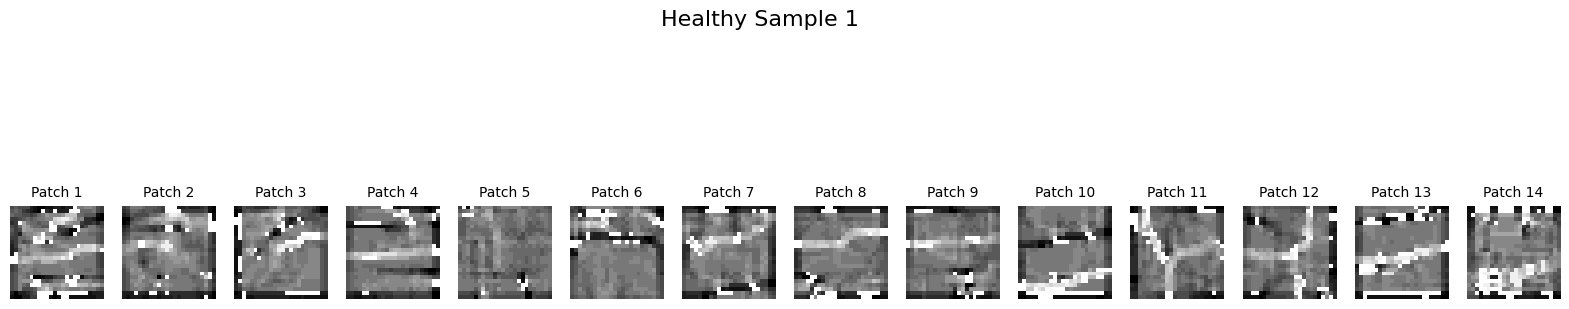

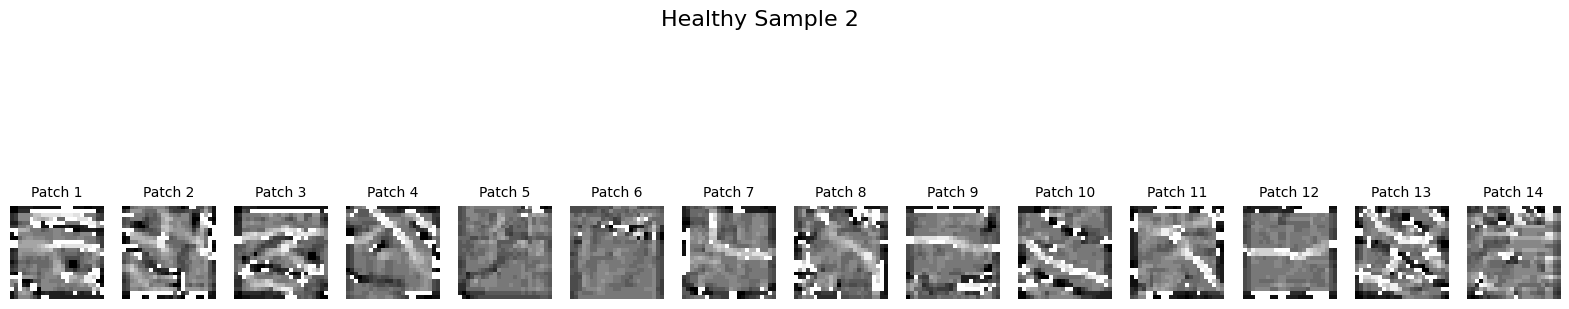

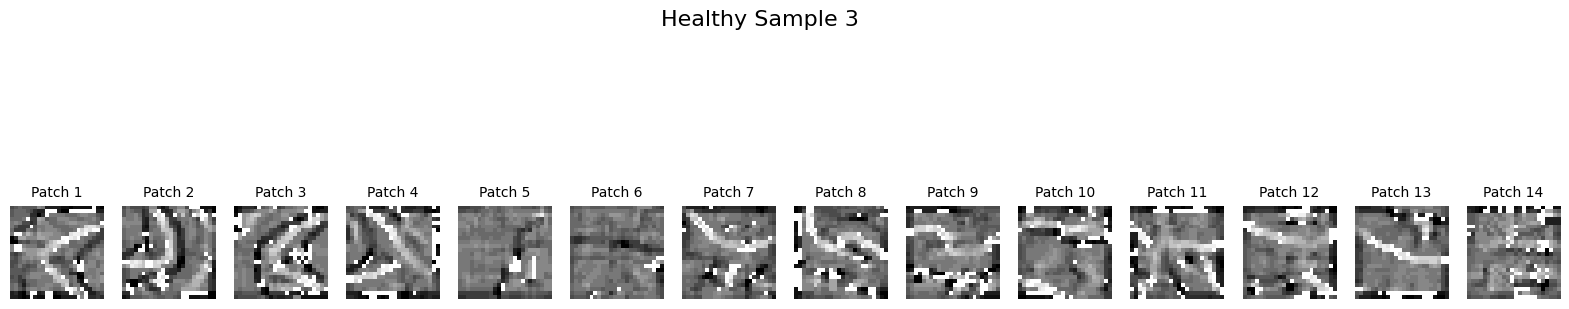

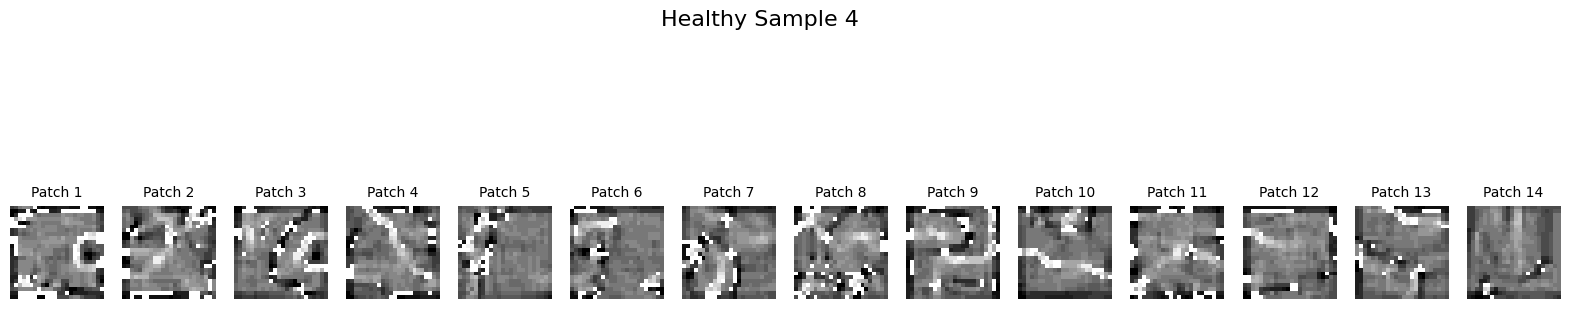

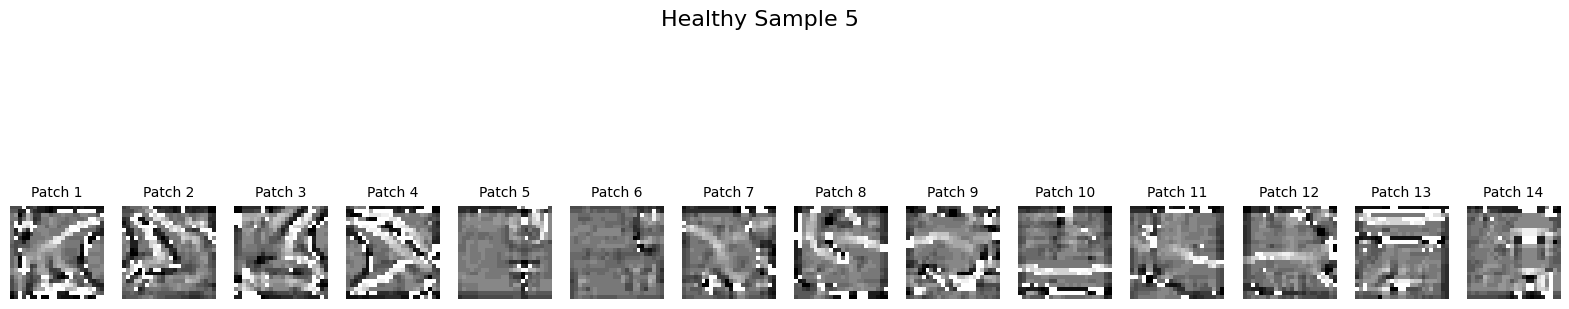

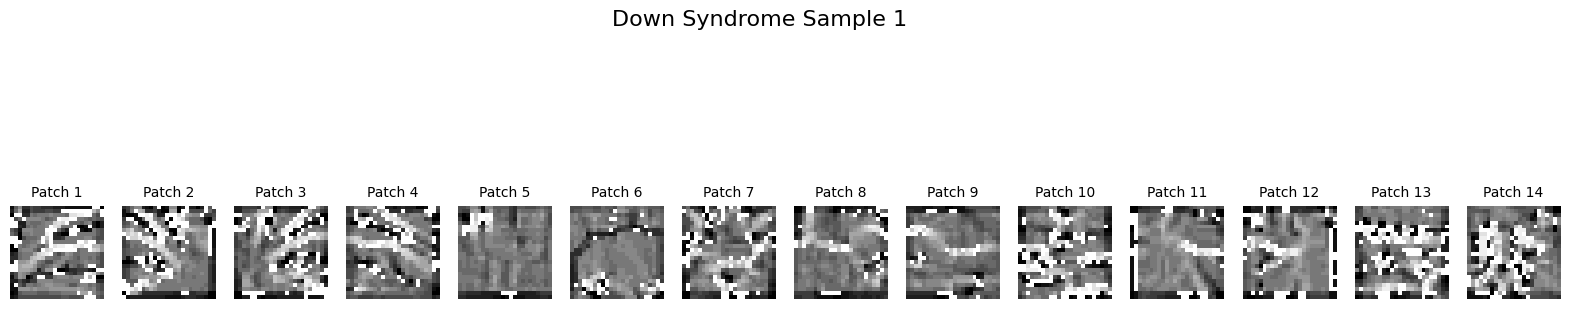

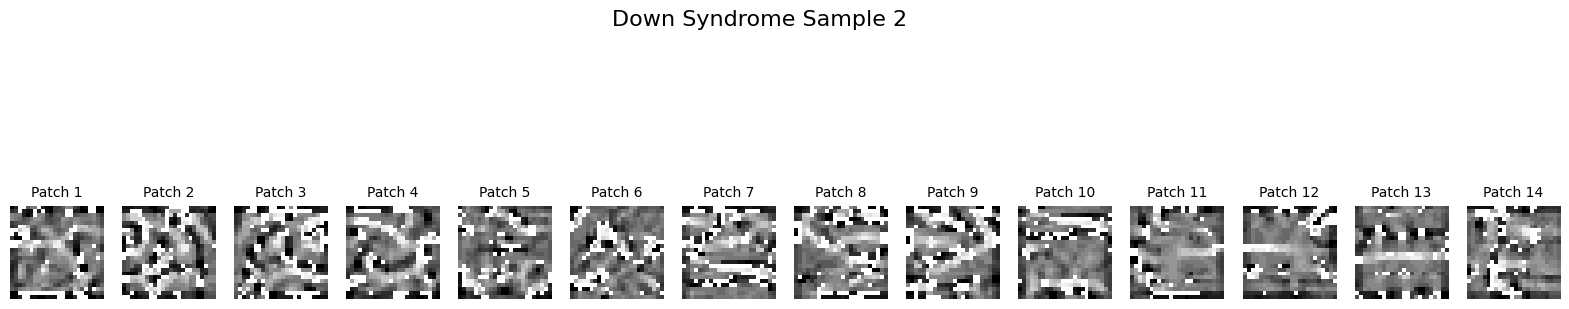

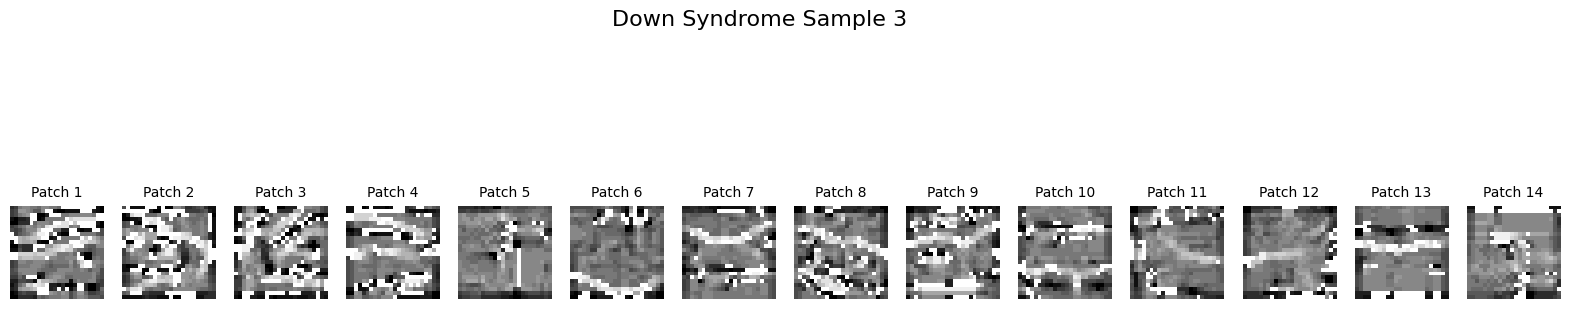

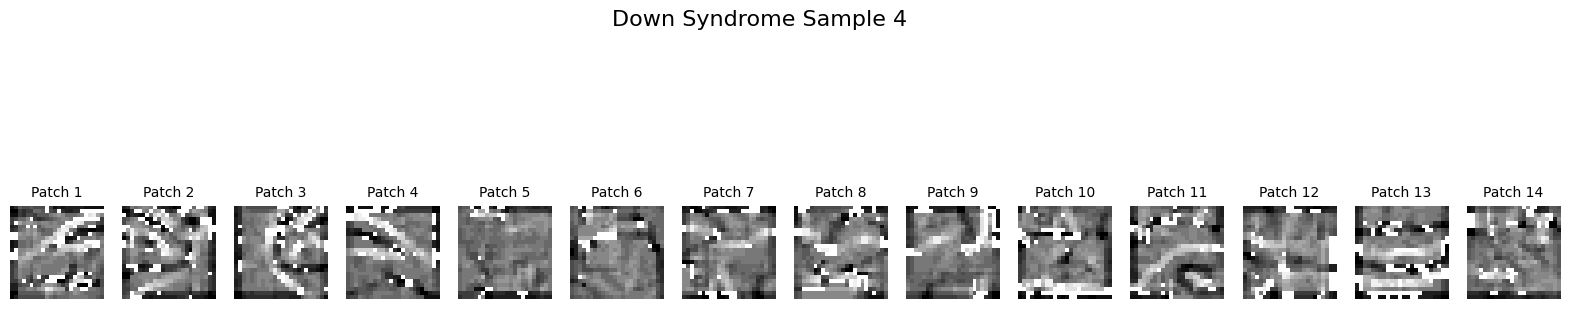

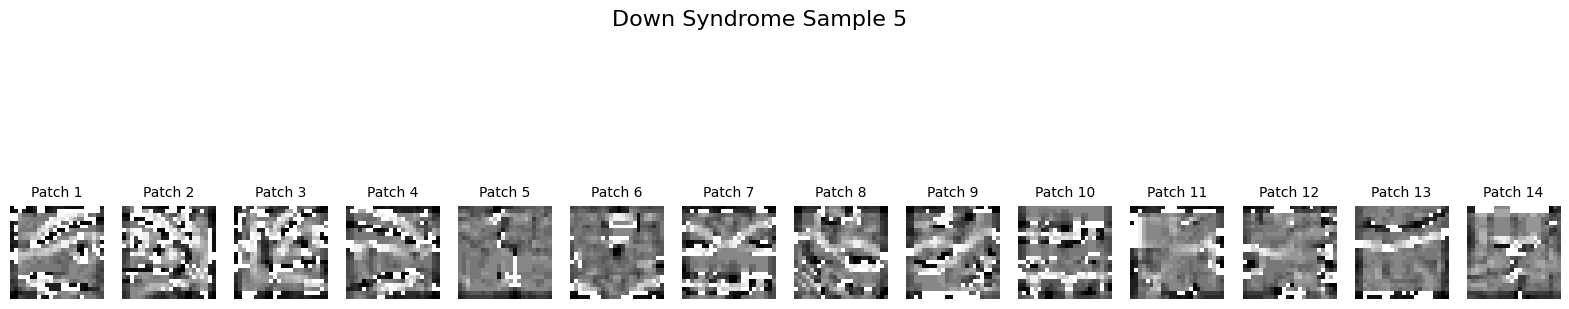

In [102]:
import matplotlib.pyplot as plt

def visualize_lbp_patches(image, patches, title):
    plt.figure(figsize=(20, 5))
    for i, patch in enumerate(patches):
        lbp = local_binary_pattern(patch, POINTS, RADIUS, METHOD)
        plt.subplot(1, len(patches), i + 1)
        plt.imshow(lbp, cmap='gray')
        plt.title(f'Patch {i + 1}', fontsize=10) 
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display 5 samples of each category
num_samples = 5
healthy_images = [img for img in os.listdir(healthy_path)]
down_syndrome_images = [img for img in os.listdir(down_syndrome_path)]
# print(indices)
healthy_count = 0
down_syndrome_count = 0

# Plot healthy samples with LBP patches
for i, img_file in enumerate(healthy_images):
    if healthy_count >= num_samples:
        break
    img_path = os.path.join(healthy_path, img_file)
    img = cv2.imread(img_path)
    landmarks = get_landmarks(img_path)
    if landmarks and is_frontal_face(landmarks):
        patches = extract_patches(img, landmarks, landmark_indices)
        visualize_lbp_patches(img, patches, f'Healthy Sample {healthy_count + 1}')
        healthy_count += 1

# Plot Down syndrome samples with LBP patches
for i, img_file in enumerate(down_syndrome_images):
    if down_syndrome_count >= num_samples:
        break
    img_path = os.path.join(down_syndrome_path, img_file)
    img = cv2.imread(img_path)
    landmarks = get_landmarks(img_path)
    if landmarks and is_frontal_face(landmarks):
        patches = extract_patches(img, landmarks, landmark_indices)
        visualize_lbp_patches(img, patches, f'Down Syndrome Sample {down_syndrome_count + 1}')
        down_syndrome_count += 1
